In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
!pip install SimpleITK pydicom scikit-learn scikit-fuzzy
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage as ndi
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
from PIL import ImageOps
import SimpleITK as sitk
import cv2
from skimage import color,filters
import skimage
from past.builtins import xrange
from skimage import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import skfuzzy as fuzz
import argparse
from time import time
import tensorflow as tf
# Import Packs
import numpy as np #Version: v1.14.3
import pydicom as dc # v1.0.2
import glob
import matplotlib.pyplot as plt #v2.1.2
from matplotlib import rcParams
from skimage import segmentation, color
from skimage.io import imread
from skimage.future import graph
from matplotlib import pyplot as plt

In [ ]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    print(slices[0].pixel_array)
    return slices

In [ ]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

In [ ]:
data_path = "/content/drive/My Drive/3Dircadb1.9/PATIENT_DICOM"
patient = load_scan(data_path)
patient_imgs = get_pixels_hu(patient)


[[-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 ...
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]]


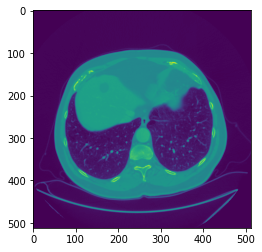

In [ ]:
plt.imshow(patient_imgs[88])

In [ ]:
output_path = working_path = "/content/drive/My Drive/3Dircadb1.9/PATIENT_DICOMOUTPUT"
np.save(output_path + "fullimages_%d.npy" % (0), patient_imgs)

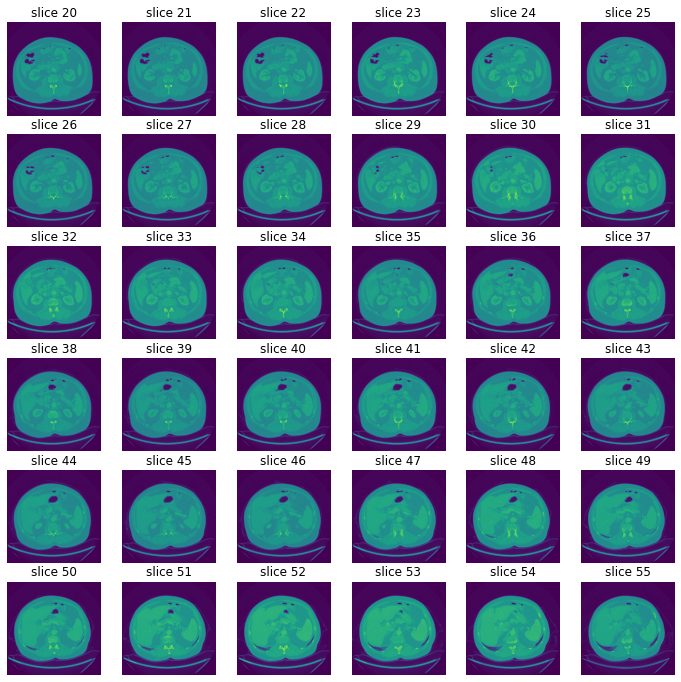

In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=20, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind])
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)
org_imgs = imgs_to_process.copy()

In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

In [ ]:
def crop(img):
    return img[100:400,30:350]

In [ ]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

In [ ]:
def threshold(img): 
    img = img.astype(np.uint8)
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

In [ ]:
def erode(img):
    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        img =cv2.erode(img,kernel,iterations = 2)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

        img = cv2.dilate(img,kernel,iterations = 3)

        return img

In [ ]:
def contours(img):
    objects = np.zeros([img.shape[0], img.shape[1], 3], 'uint8')
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    color = (255, 255, 255) 
    c = max(contours, key = cv2.contourArea)
    cv2.drawContours(objects, [c], -1, color, -1)

    return objects

In [ ]:
def make_mask(largest_shape):

    #largest_shape = cv2.cvtColor(largest_shape, cv2.COLOR_BGR2GRAY)
    ret,mask = cv2.threshold(largest_shape,120,255,cv2.THRESH_BINARY)
    new_mask = np.zeros([imgs_to_process[0].shape[0], imgs_to_process[0].shape[1]], 'uint8')
    #print(new_mask)
    new_mask[100:400,30:350] = mask
    
    return new_mask

In [ ]:
def check_axis(img):
    largest_shape = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    m = cv2.moments(largest_shape)
    cx = int(((m["m10"]) / (m["m00"])))
    cy = int(( (m["m01"]) / (m["m00"])))
    #print(cy)
    if cy > 180:
        return np.zeros([img.shape[0], img.shape[1]], 'uint8')
    else:
        return largest_shape

In [ ]:
def segement_liver(img, mask):
    return  cv2.bitwise_and(img, mask)

In [ ]:
def liver_extraction(img_to_process):
    org =np.uint8(cv2.normalize(img_to_process, None, 0, 255, cv2.NORM_MINMAX))
    croped_image = crop(img_to_process)
    enhanced_image = image_histogram_equalization(croped_image)
    threshold_image = threshold(enhanced_image)
    eroded_image = erode(threshold_image)
    largest_shape = contours(eroded_image)
    checked = check_axis(largest_shape)
    src2 = make_mask(checked)
    src2  = np.float64(src2)
    liver_masks.append(src2)
    src1 = image_histogram_equalization(org) 
    final = segement_liver(src1,src2)
    return final

In [ ]:
#mean union intersection (mui)
def score(predicted,true):
    predict = predicted/255
    y_train = true/255
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(predict, y_train)
    return m.result().numpy()


111


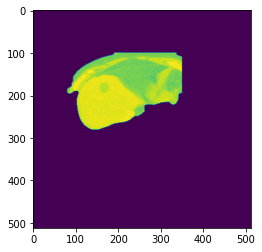

In [ ]:
predicted = []
liver_masks = []
for slice in range(len(imgs_to_process)):
    final = liver_extraction(imgs_to_process[slice])
    predicted.append(final)

plt.imshow(predicted[88])
print(len(predicted))

111


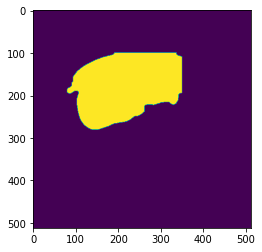

In [ ]:
plt.imshow(liver_masks[88])
print(len(liver_masks))

In [ ]:
data_path = "/content/drive/My Drive/3Dircadb1.1/MASKS_DICOM/liver"
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
output_path = working_path = "/content/drive/My Drive/3Dircadb1.1/PATIENT_DICOMOUTPUT"
np.save(output_path + "fullimages_%d.npy" % (0), imgs)
file_used=output_path+"fullimages_%d.npy" % (0)
livers_to_process = np.load(file_used).astype(np.float64) 

print ("Shape before resampling\t", livers_to_process.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape before resampling	 (129, 512, 512)


In [ ]:
liver_true = []
for slice in range(len(livers_to_process)):
    org1 =np.uint8(cv2.normalize(livers_to_process[slice], None, 0, 255, cv2.NORM_MINMAX))
    ret3,org = cv2.threshold(org1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    org1  = np.float64(org1)
    liver_true.append(org1)

In [ ]:
def tumor_mask_extraction(predicted):
    org =np.uint8(cv2.normalize(predicted, None, 0, 255, cv2.NORM_MINMAX))
    croped_image = crop(org)
    img_segments = segmentation.slic(croped_image, compactness=0.1, n_segments=200)
    superpixels = color.label2rgb(img_segments, croped_image, kind='avg')
    enhanced_image = image_histogram_equalization(superpixels)
    threshold_image = threshold(enhanced_image)
    new_mask = np.ones([imgs_to_process[0].shape[0], imgs_to_process[0].shape[1]], 'uint8')
    new_mask[100:400,30:350] = threshold_image
    return np.float64(new_mask)

In [ ]:
 def tumor_extraction(src2,predicted):
    org =np.uint8(cv2.normalize(predicted, None, 0, 255, cv2.NORM_MINMAX))   
    src1 = image_histogram_equalization(org) 
    final = cv2.bitwise_and(src1,src2)
    final = skimage.morphology.closing(final)
    final = cv2.bitwise_not(final)
    final = cv2.bitwise_and(final,predicted)
    return final

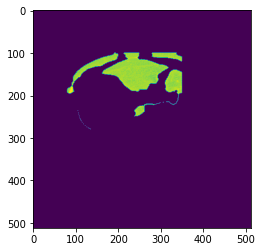

In [ ]:
tumor = []
tumor_masks = []
for slice in range(len(predicted)):

    src2  = tumor_mask_extraction(predicted[slice])
    tumor_masks.append(cv2.bitwise_xor(src2,liver_masks[slice]))

    final =  tumor_extraction(src2,predicted[slice])
    tumor.append(final)
    

plt.imshow(tumor[88])

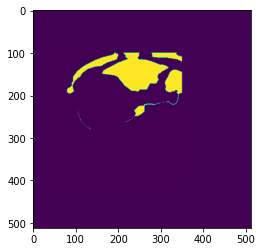

In [ ]:
plt.imshow(tumor_masks[88])

In [ ]:
data_path = "/content/drive/My Drive/3Dircadb1.9/MASKS_DICOM/livertumor"
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
output_path = working_path = "/content/drive/My Drive/3Dircadb1.9/PATIENT_DICOMOUTPUT"
np.save(output_path + "fullimages_%d.npy" % (0), imgs)
file_used=output_path+"fullimages_%d.npy" % (0)
tumors_to_process = np.load(file_used).astype(np.float64) 


true = []
for slice in range(len(tumors_to_process)):
    org =np.uint8(cv2.normalize(tumors_to_process[slice], None, 0, 255, cv2.NORM_MINMAX))
    ret3,org = cv2.threshold(org,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    org  = np.float64(org)
    true.append(org)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
tumor_masks_1 = np.stack([s for s in tumor_masks])
liver_masks_1 = np.stack([s for s in liver_masks])

In [ ]:
true_1 = np.stack([s for s in true])
liver_true_1 = np.stack([s for s in liver_true])

In [ ]:
score(tumor_masks_1,true_1)

In [ ]:
score(liver_masks_1,liver_true_1)